# Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from gemseo.algos.parameter_space import ParameterSpace
from gemseo import from_pickle
from lh2pac.utils import update_default_inputs
from gemseo.algos.design_space import DesignSpace
from gemseo_oad_training.unit import convert_from
from gemseo_umdo.scenarios.umdo_scenario import UMDOScenario
from gemseo_umdo.formulations.sampling_settings import Sampling_Settings
from gemseo_oad_training.utils import draw_aircraft
from gemseo_oad_training.utils import AircraftConfiguration
import pandas as pd


configure_logger()

<RootLogger root (INFO)>

# Compute constraints

In [2]:
def build_constraints_dataframe(constraints, margins):
    """
    Construit un DataFrame récapitulatif des contraintes à partir des dictionnaires constraints et margins.

    Args:
        constraints (dict): Dictionnaire des contraintes avec seuil, facteur et signe.
        margins (dict): Dictionnaire des marges standardisées.

    Returns:
        pd.DataFrame: DataFrame récapitulatif.
    """
    data = []

    for key, params in constraints.items():
        M = margins[key]
        s = params['seuil']
        f = abs(params['factor'])
        pos = params['positive']

        if pos:
            v = s - M / f
        else:
            v = s + M / f

        status = 'Respectée' if M < 0 else 'Non respectée'

        data.append({
            'Contrainte': key,
            'Seuil': s,
            'Facteur abs': f,
            'Marge standardisée': M,
            'Valeur réelle': v,
            'Statut': status
        })

    return pd.DataFrame(data)

# Instanciate disciplines

In [3]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

In [4]:
update_default_inputs(disciplines, {"fuel_type": "liquid_h2"})
disciplines[5].io.input_grammar.defaults

{'fuel_type': 'liquid_h2', 'gi': 0.4, 'tkv': 20.0}

# Create design space for the original disciplines

In [5]:
# Create the design space
design_space = DesignSpace()
design_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

# Create uncertain space

In [6]:
uncertain_space = ParameterSpace()

uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("gi", "OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi", "OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)

# Add constraints

In [7]:
scenario = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

In [8]:
# Add the constraints
scenario.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

# Execute scenario

In [9]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 14:36:13: *** Start UMDOScenario execution ***
    INFO - 14:36:13: UMDOScenario
    INFO - 14:36:13:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:36:13:    Formulation:
    INFO - 14:36:13:       MDO formulation: MDF
    INFO - 14:36:13:       Statistic estimation: Sampling
    INFO - 14:36:13:    Uncertain space:
    INFO - 14:36:13:       +------+------------------------------------------------+
    INFO - 14:36:13:       | Name |                  Distribution                  |
    INFO - 14:36:13:       +------+------------------------------------------------+
    INFO - 14:36:13:       | aef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 14:36:13:       | cef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 14:36:13:       | sef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 14:36:13:       |  gi  | Triangular(lower=0.35, mode=0.4,

In [10]:
# scenario.post_process(post_name="OptHistoryView", save=False, show=True)

In [11]:
result = scenario.optimization_result
(result.constraint_values)

{'[Margin[tofl; 2.0]-1900.0]': array([4.71404292e-07]),
 '[Margin[vapp; 2.0]-69.44999999400001]': array([4.25715996e-09]),
 '-[Margin[vz; -2.0]-1.524]': array([-0.2304578]),
 '[Margin[span; 2.0]-40.0]': array([-6.81494988]),
 '[Margin[length; 2.0]-45.0]': array([-10.25]),
 '-Margin[fm; -2.0]': array([9.25338833e-11])}

In [12]:
constraints = {
    'tofl': {'seuil': 1900.0, 'factor': 2.0, 'positive': False},
    'vapp': {'seuil': 69.45, 'factor': 2.0, 'positive': False},
    'vz': {'seuil': 1.524, 'factor': -2.0, 'positive': True},
    'span': {'seuil': 40.0, 'factor': 2.0, 'positive': False},
    'length': {'seuil': 45.0, 'factor': 2.0, 'positive': False},
    'fm': {'seuil': 0.0, 'factor': -2.0, 'positive': True},
}


margins = {
    'tofl': 4.71404292e-07,
    'vapp': 4.25715996e-09,
    'vz': -0.2304578,
    'span': -6.81494988,
    'length': -10.25,
    'fm': 9.25338833e-11,
}

build_constraints_dataframe(constraints, margins)

,Contrainte,Seuil,Facteur abs,Marge standardisée,Valeur réelle,Statut
0,tofl,1900.000,2.0,4.714043e-07,1.900000e+03,Non respectée
1,vapp,69.450,2.0,4.257160e-09,6.945000e+01,Non respectée
2,vz,1.524,2.0,-2.304578e-01,1.639229e+00,Respectée
3,span,40.000,2.0,-6.814950e+00,3.659253e+01,Respectée
4,length,45.000,2.0,-1.025000e+01,3.987500e+01,Respectée
5,fm,0.000,2.0,9.253388e-11,-4.626694e-11,Non respectée


# Import surrogate model

In [13]:
surrogate_disciplines = from_pickle("UC2_my_surrogate_3.pkl")
surrogate_disciplines

Surrogate discipline: RBF_Sampling
   Dataset name: Sampling
   Dataset size: 28
   Surrogate model: RBFRegressor
   Inputs: aef, ar, area, cef, n_pax, sef, slst
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

# Create a new design space


In [14]:
design_space_surrogate = DesignSpace()
design_space_surrogate.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space_surrogate.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space_surrogate.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space_surrogate.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [15]:
uncertain_space_surrogate = ParameterSpace()
uncertain_space_surrogate.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("gi", "OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space_surrogate.add_random_variable("vi", "OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)

In [16]:
scenario_surrogate = UMDOScenario(
    [surrogate_disciplines],
    "mtom",
    design_space_surrogate,
    uncertain_space_surrogate,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

 WARNING - 14:37:14: No coupling in MDA, switching chain_linearize to True.
 WARNING - 14:37:14: No coupling in MDA, switching chain_linearize to True.
    INFO - 14:37:14: Variable gi was removed from the Design Space, it is not an input of any discipline.
    INFO - 14:37:14: Variable vi was removed from the Design Space, it is not an input of any discipline.


In [17]:
# Add the constraints
scenario_surrogate.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario_surrogate.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [18]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 14:37:14: *** Start UMDOScenario execution ***
    INFO - 14:37:14: UMDOScenario
    INFO - 14:37:14:    Disciplines: RBF_Sampling
    INFO - 14:37:14:    Formulation:
    INFO - 14:37:14:       MDO formulation: MDF
    INFO - 14:37:14:       Statistic estimation: Sampling
    INFO - 14:37:14:    Uncertain space:
    INFO - 14:37:14:       +------+--------------------------------------------+
    INFO - 14:37:14:       | Name |                Distribution                |
    INFO - 14:37:14:       +------+--------------------------------------------+
    INFO - 14:37:14:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 14:37:14:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 14:37:14:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 14:37:14:       +------+--------------------------------------------+
    INFO - 14:37:14: Optimization problem:
    INFO - 14:37:14:    minimize E[mtom]
    INFO - 14:37:14:   

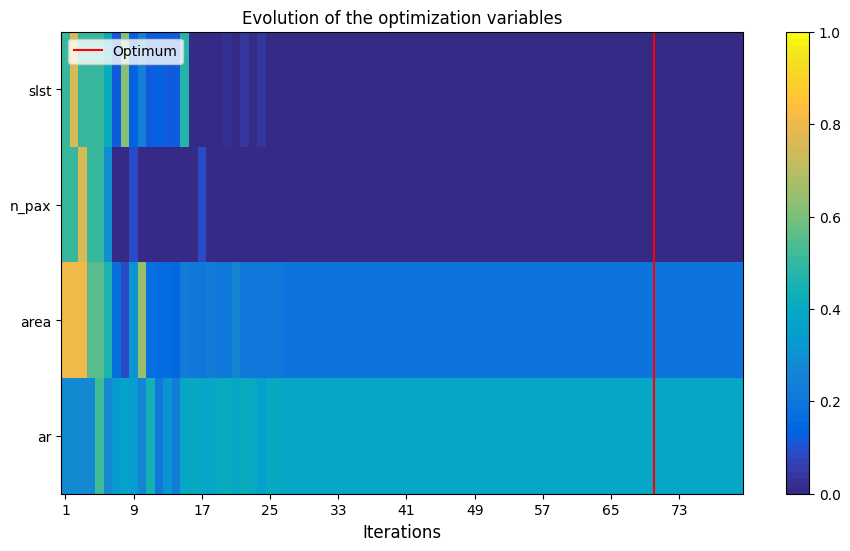

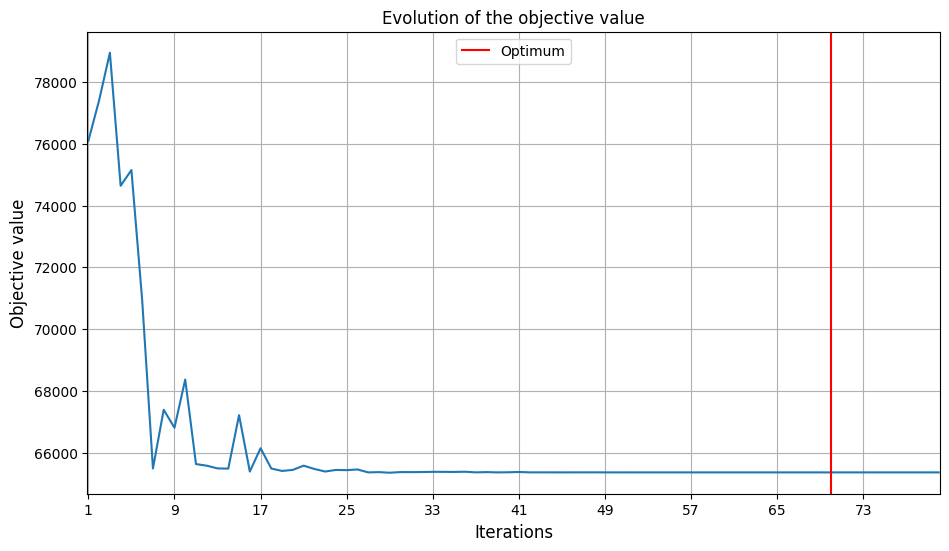

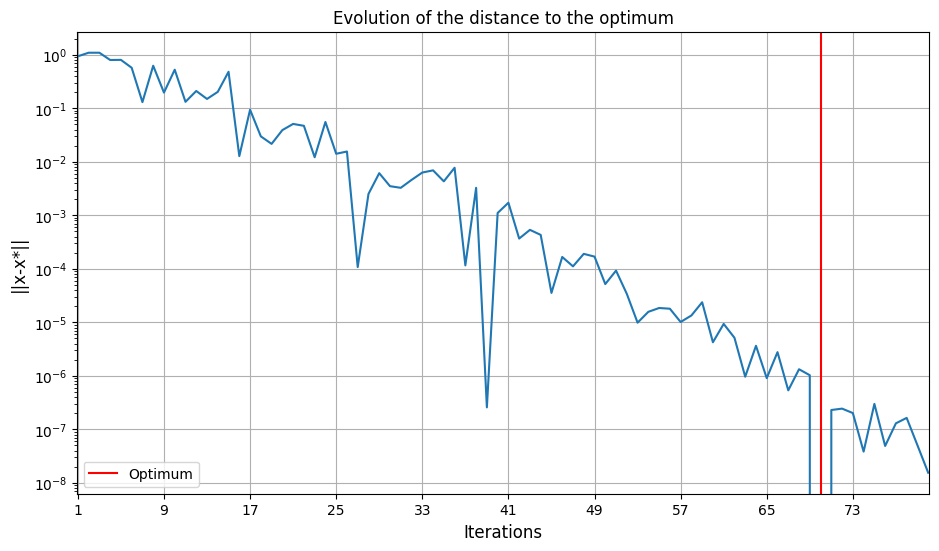

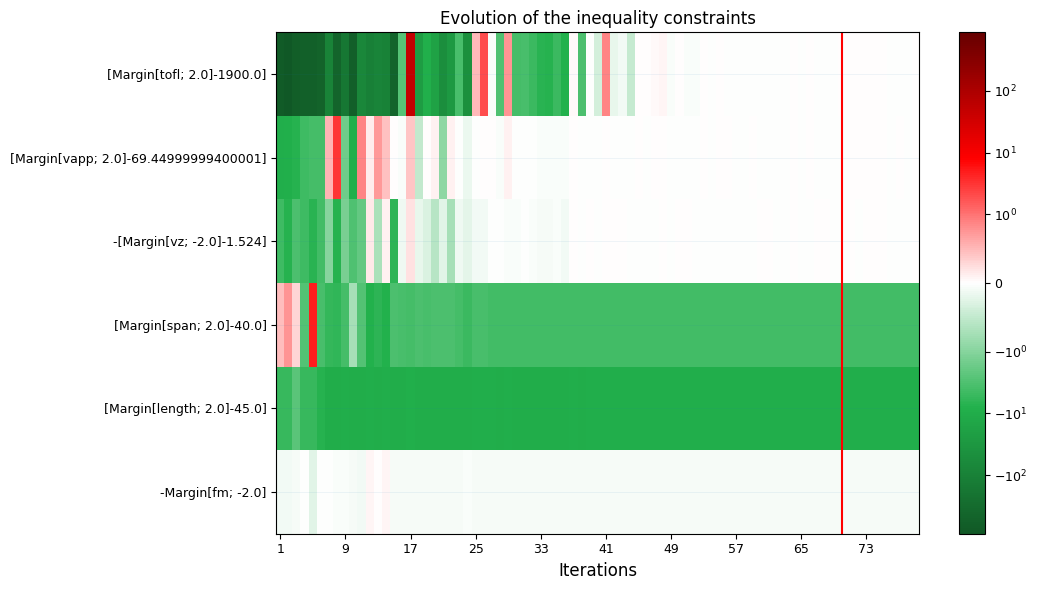

In [19]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)

# Evaluate surrogate optimum in the original model

## Compare results

In [20]:
scenario.optimization_result.x_opt_as_dict

{'slst': array([101202.59098526]),
 'n_pax': array([120.]),
 'area': array([115.77575615]),
 'ar': array([9.51190118])}

## Evaluate optimum

In [21]:
scenario_surrogate.optimization_result.x_opt_as_dict

{'slst': array([100094.7415271]),
 'n_pax': array([120.]),
 'area': array([120.07180207]),
 'ar': array([10.69330667])}

In [22]:
scenario_test = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

In [23]:
# Add the constraints
scenario_test.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario_test.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [24]:
scenario_test.execute(algo_name = 'CustomDOE', samples = [scenario_surrogate.optimization_result.x_opt_as_dict])

    INFO - 14:38:07: *** Start UMDOScenario execution ***
    INFO - 14:38:07: UMDOScenario
    INFO - 14:38:07:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:38:07:    Formulation:
    INFO - 14:38:07:       MDO formulation: MDF
    INFO - 14:38:07:       Statistic estimation: Sampling
    INFO - 14:38:07:    Uncertain space:
    INFO - 14:38:07:       +------+------------------------------------------------+
    INFO - 14:38:07:       | Name |                  Distribution                  |
    INFO - 14:38:07:       +------+------------------------------------------------+
    INFO - 14:38:07:       | aef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 14:38:07:       | cef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 14:38:07:       | sef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 14:38:07:       |  gi  | Triangular(lower=0.35, mode=0.4,

In [25]:
result_surr = scenario_test.optimization_result
(result_surr.constraint_values)

{'[Margin[tofl; 2.0]-1900.0]': array([-32.13016702]),
 '[Margin[vapp; 2.0]-69.44999999400001]': array([-0.932327]),
 '-[Margin[vz; -2.0]-1.524]': array([-0.92784496]),
 '[Margin[span; 2.0]-40.0]': array([-4.16754821]),
 '[Margin[length; 2.0]-45.0]': array([-10.25]),
 '-Margin[fm; -2.0]': array([-0.06919158])}

In [27]:
constraints = {
    'tofl': {'seuil': 1900.0, 'factor': 2.0, 'positive': False},
    'vapp': {'seuil': 69.45, 'factor': 2.0, 'positive': False},
    'vz': {'seuil': 1.524, 'factor': -2.0, 'positive': True},
    'span': {'seuil': 40.0, 'factor': 2.0, 'positive': False},
    'length': {'seuil': 45.0, 'factor': 2.0, 'positive': False},
    'fm': {'seuil': 0.0, 'factor': -2.0, 'positive': True},
}


margins_surrogate = {
    'tofl': -32.13544143,
    'vapp': -0.93234455,
    'vz': -0.92786223,
    'span': -4.16760608,
    'length': -10.25,
    'fm': -0.06918977,
}

build_constraints_dataframe(constraints, margins_surrogate)

,Contrainte,Seuil,Facteur abs,Marge standardisée,Valeur réelle,Statut
0,tofl,1900.000,2.0,-32.135441,1883.932279,Respectée
1,vapp,69.450,2.0,-0.932345,68.983828,Respectée
2,vz,1.524,2.0,-0.927862,1.987931,Respectée
3,span,40.000,2.0,-4.167606,37.916197,Respectée
4,length,45.000,2.0,-10.250000,39.875000,Respectée
5,fm,0.000,2.0,-0.069190,0.034595,Respectée


# Draw aircrafts

In [28]:
AC1 =AircraftConfiguration(name = 'x_base', length= 39.87, span = 36.59, area = 115.7757561539011, color = 'blue')
AC2 =AircraftConfiguration(name = 'x_surrogate', length= 39.88, span = 37.91 , area = 120.0718772029979, color = 'orange')
AC3 =AircraftConfiguration(name = 'x_default', length= 42.37, span = 40.12, area = 200, color = 'green')

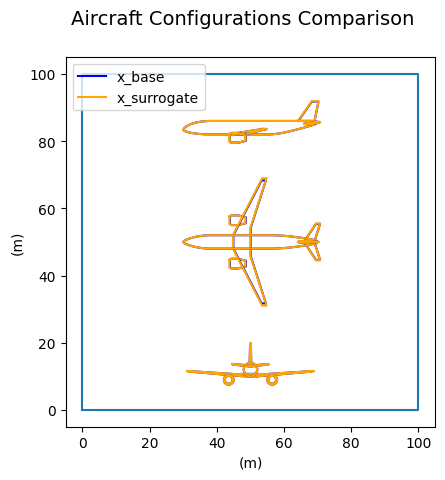

In [29]:
draw_aircraft(AC1, AC2, title="Aircraft Configurations Comparison", save=False, show=True)

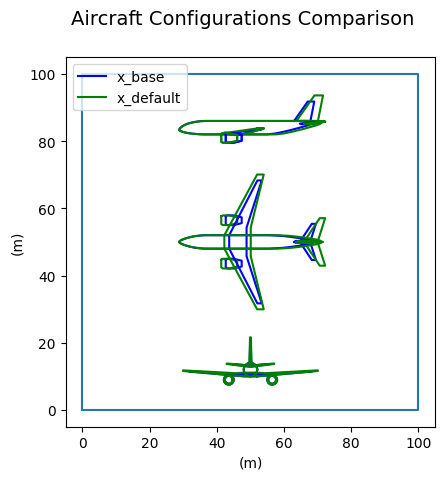

In [18]:
draw_aircraft(AC1, AC3, title="Aircraft Configurations Comparison", save=False, show=True)